## Приближение взаимной информации в вершине с помощью нейронных сетей
### Лунин Дмитрий, 25.02.2016

При поиске структуры байесовской сети возникает задача поиска набора родителей вершины, который максимизирует общую информацию (возможно, с некоторой регуляризацией). Проблема в том, что для достаточно больших сетей таких наборов может быть очень много. Возможно, в функции общей информации есть скрытые закономерности, которые помогут эффективнее ее оптимизировать. Для их поиска можно использовать нейронные сети.

Здесь с помощью нейронных сетей строится приближение функции информации; при этом получается неплохой результат.

In [1]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [3]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

Загружаем байесовскую сеть insurance -- в ней достаточно вершин, чтобы задача была нетривиальной, но при этом вычисления не занимают много времени.

In [4]:
dgm = gm.DGM.read('../networks/alarm.bif')

In [5]:
n_nodes = len(dgm.nodes()) # количество вершин
n_nodes

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


37

In [6]:
from math import factorial
k = 5
# количество вариантов выбора родителей вершины, при условии что их не больше k.
factorial(n_nodes - 1) / factorial(n_nodes - k - 1) / factorial(k)

376992L

In [7]:
dgm.draw()

Генерируем данные из байесовской сети.

In [8]:
data = dgm.rvs(size=100000)

Рассмотрим вершину Antilock

In [9]:
target = 'CATECHOL'
fact = dgm.cpd(target)
fact

INSUFFANESTH,TPR,SAO2,ARTCO2,CATECHOL,Prob.
TRUE,LOW,LOW,LOW,NORMAL,0.010
TRUE,LOW,LOW,LOW,HIGH,0.990
TRUE,LOW,LOW,NORMAL,NORMAL,0.010
TRUE,LOW,LOW,NORMAL,HIGH,0.990
TRUE,LOW,LOW,HIGH,NORMAL,0.010
TRUE,LOW,LOW,HIGH,HIGH,0.990
TRUE,LOW,NORMAL,LOW,NORMAL,0.010
TRUE,LOW,NORMAL,LOW,HIGH,0.990
TRUE,LOW,NORMAL,NORMAL,NORMAL,0.010
TRUE,LOW,NORMAL,NORMAL,HIGH,0.990


In [29]:
def bic_score(l, k, n):
    return -2 * np.log(l) + k*np.log(n)

In [33]:
def generate_subset(target, factor, N, kmin=1, kmax=4, size=1):
    """
    Generate `size` random subsets of parents for node `target` with factor `factor` 
    and calculate discrete mutual information for them.
    Number of parents lies between kmin and kmax
    """
    arguments = list(factor.arguments)
    arguments.remove(target)
    arguments = np.asarray(arguments)
    
    n = np.random.randint(low=kmin, high=kmax+1, size=size)
    result = []
    score = []
    for i, cn in enumerate(n):
        current = np.random.choice(arguments, size=cn, replace=False)
        result.append([1.0 if arg in current else 0.0 for arg in arguments])
        cscore = gm.information.discrete_mutual_information(data[[target]], data[current])
        k = np.prod([factor.n_values(var) for i, var in enumerate(arguments) if result[-1][i]])
        cscore = bic_score(cscore, k, N)
        score.append(cscore)
    return np.vstack(result), np.hstack(score)

In [34]:
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['HISTORY', 'CVP', 'PCWP', 'HYPOVOLEMIA', 'LVEDVOLUME', 'LVFAILURE', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HREKG', 'ERRCAUTER', 'HRSAT', 'INSUFFANESTH', 'ANAPHYLAXIS', 'TPR', 'EXPCO2', 'KINKEDTUBE', 'MINVOL', 'FIO2', 'PVSAT', 'SAO2', 'PAP', 'PULMEMBOLUS', 'SHUNT', 'INTUBATION', 'PRESS', 'DISCONNECT', 'MINVOLSET', 'VENTMACH', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'ARTCO2', 'HR', 'CO', 'BP']
36


#### Генерация обучающей выборки для нейросети

In [35]:
X_train, y_train = generate_subset(target, fact, data.shape[0], kmin=1, kmax=5, size=1000)

In [36]:
%%capture
import theano
import theano.tensor as T
from theano.tensor import nnet

In [37]:
class Neurofunction:
    def __init__(self, n_in, n_hid, lambda_=1e-4):
        self.n_in = n_in
        self.n_hid = n_hid
        self.n_params = (self.n_in + 2) * self.n_hid + 1
        
        self.W0 = T.dmatrix('W0')
        self.b0 = T.dvector('b0')
        self.W1 = T.dvector('W1')
        self.b1 = T.dscalar('b1')

        self.X = T.dmatrix('X')
        self.x = T.dvector('x')
        self.y = T.dvector('y')
        
        self.hidden = nnet.sigmoid(self.X.dot(self.W0) + self.b0)
        self.xhidden = nnet.sigmoid(self.x.dot(self.W0) + self.b0)
        self.out = self.hidden.dot(self.W1) + self.b1
        self.xout = self.xhidden.dot(self.W1) + self.b1
        
        self.loss = T.mean((self.out - self.y) ** 2) + lambda_ * (T.sum(self.W0 ** 2) + T.sum(self.W1 ** 2))
        
        self.theta_grad = T.concatenate([T.grad(self.loss, wrt=self.W0).flatten(),
                              T.grad(self.loss, wrt=self.W1).flatten(),
                              T.grad(self.loss, wrt=self.b0).flatten(),
                              [T.grad(self.loss, wrt=self.b1)]])
        self.loss_theta_grad_f = theano.function(inputs=[self.X, self.y, self.W0, self.W1, self.b0, self.b1],
                                           outputs=[self.loss, self.theta_grad])
        self.predict_f = theano.function(inputs=[self.X, self.W0, self.W1, self.b0, self.b1], 
                                         outputs=self.out, name='predict')
        
        self.x_grad = T.grad(-self.xout, wrt=self.x)
        self.loss_x_grad_f = theano.function(inputs=[self.x, self.W0, self.W1, self.b0, self.b1], 
                                            outputs=[-self.xout, self.x_grad])
    
        
    def _parse_params(self, theta):
        n_in = self.n_in
        n_hid = self.n_hid
        n_out = 1
        W0 = theta[:n_in*n_hid].reshape((n_in, n_hid))
        W1 = theta[n_in*n_hid:n_in*n_hid + n_hid*n_out]
        b0 = theta[n_in*n_hid + n_hid*n_out:n_in*n_hid + n_hid*n_out + n_hid]
        b1 = theta[n_in*n_hid + n_hid*n_out + n_hid]
        return W0, W1, b0, b1
        
    def fit(self, X, y):
        theta = np.random.rand(self.n_params)
        
        def loss_grad(theta):
            W0, W1, b0, b1 = self._parse_params(theta)
            return self.loss_theta_grad_f(X, y, W0, W1, b0, b1)
    
        res = sp.optimize.minimize(loss_grad, theta, method='L-BFGS-B', jac=True)
        self.theta = res['x']
        
    def __call__(self, X):
        params = self._parse_params(self.theta)
        return self.predict_f(np.atleast_2d(X), *params)
    
    def maximize(self, assignment=None):
        if assignment is None:
            assignment = [None] * self.n_in
        
        n_assigned = sum([1 if a is not None else 0 for a in assignment])
        x = np.random.rand(self.n_in - n_assigned)
        idx = [i for i, a in enumerate(assignment) if a is None]
        
        
        dispatch = {}
        for i, a in enumerate(assignment):
            if a is None:
                dispatch[len(dispatch)] = i
        
        def loss_grad(x_compl):
            x = np.array(assignment)
            for i, xi in enumerate(x_compl):
                x[dispatch[i]] = xi
            W0, W1, b0, b1 = self._parse_params(self.theta)
            loss, grad = self.loss_x_grad_f(x.astype('float'), W0, W1, b0, b1)
            grad = grad[idx]
            return loss, grad
        
        res = sp.optimize.minimize(loss_grad, x, method='L-BFGS-B', jac=True, 
                                   bounds=[(0, 1)] * (self.n_in - n_assigned))
        return res['x']

In [38]:
X_train.shape, y_train.shape

((1000, 36), (1000,))

In [39]:
nf = Neurofunction(X_train.shape[1], 3, lambda_=0.0001)
nf.fit(X_train, y_train)

#### Генерация тестовой выборки

In [42]:
X_test, y_test = generate_subset(target, fact, data.shape[0], kmin=4, kmax=5, size=100)

# Некоторые наборы уже были в обучающей выборке, поэтому мы их выбрасываем.
train_set = set(map(tuple, X_train))
idx = [i for i, x in enumerate(X_test) if tuple(x) not in train_set]
X_test = X_test[idx]
y_test = y_test[idx]
print('accepted', len(idx))

('accepted', 100)


In [43]:
# mean absolute error для тестовой выборки
np.mean(np.abs(nf(X_test) - y_test))

5.661494044144888

Интересно посмотреть, насколько отличаются оптимальный набор найденный по нейронной сети от реального оптимального набора (среди тестовой выборки).

In [44]:
y_test[np.argmax(nf(X_test))]

313.66044002946251

In [45]:
# количество более хороших наборов, чем найденный
np.sum(y_test > y_test[np.argmax(nf(X_test))])

0

In [46]:
np.max(y_test)

313.66044002946251

(array([ 96.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  14.774237  ,   44.6628573 ,   74.5514776 ,  104.44009791,
         134.32871821,  164.21733851,  194.10595882,  223.99457912,
         253.88319942,  283.77181973,  313.66044003]),
 <a list of 10 Patch objects>)

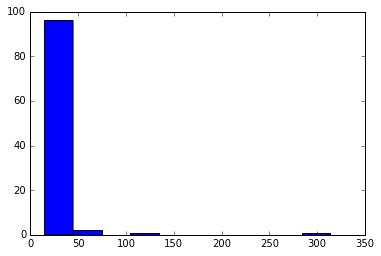

In [47]:
plt.hist(y_test)

Как видим, нейронная сеть находит неплохой набор. Значит, она обучается достаточно хорошему представлению взаимной информации в вершине.

-1

In [51]:
res = 0.5 * np.sign(nf.maximize() - 0.5) + 0.5
res

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.])

In [52]:
nf(res)

array([ 284.00113293])

In [53]:
np.X_test()

AttributeError: 'module' object has no attribute 'X_test'

### Baseline
Что если хорошее качество обусловлено тем, что данные в этом примере подчиняются очень простой закономерности и нейронные сети на самом деле не нужны? В этом разделе, попробуем приблизить взаимную информацию для набора родителей суммой взаимных информаций для каждого из них.

In [54]:
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['HISTORY', 'CVP', 'PCWP', 'HYPOVOLEMIA', 'LVEDVOLUME', 'LVFAILURE', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HREKG', 'ERRCAUTER', 'HRSAT', 'INSUFFANESTH', 'ANAPHYLAXIS', 'TPR', 'EXPCO2', 'KINKEDTUBE', 'MINVOL', 'FIO2', 'PVSAT', 'SAO2', 'PAP', 'PULMEMBOLUS', 'SHUNT', 'INTUBATION', 'PRESS', 'DISCONNECT', 'MINVOLSET', 'VENTMACH', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'ARTCO2', 'HR', 'CO', 'BP']
36


In [57]:
mi_array = np.array([bic_score(gm.information.discrete_mutual_information(data[[target]], 
                                                                          data[[current]]), 
                               fact.n_values(current), data.shape[0]) for current in args])
def score(subset):
    return np.dot(subset, mi_array)

In [59]:
X_test, y_test = generate_subset(target, fact, data.shape[0], kmin=4, kmax=5, size=100)

In [60]:
scores = score(X_test)

In [61]:
# mean absolute error для тестовой выборки
np.mean(np.abs(scores - y_test))

99.258402381477751

In [62]:
y_test[np.argmax(scores)]

74.905152340929448

In [63]:
np.max(y_test)

213.02631780296565

In [64]:
# количество более хороших наборов, чем найденный
np.sum(y_test > y_test[np.argmax(scores)])

3

Оказывается, что на практике и это можно считать хорошим приближением.

## Noisy XOR

In [29]:
arguments = ['a', 'b', 'a_xor_b']
dgm = gm.DGM()
dgm.add_nodes_from(arguments)
dgm.add_edges_from([('a', 'a_xor_b'), ('b', 'a_xor_b')])
dgm.node['a']['cpd'] = gm.TableFactor(arguments, ['a'])
dgm.node['a']['cpd'].table = np.array([[[0.5]], [[0.5]]])
dgm.node['b']['cpd'] = gm.TableFactor(arguments, ['b'])
dgm.node['b']['cpd'].table = np.array([[[0.5], [0.5]]])
dgm.node['a_xor_b']['cpd'] = gm.TableFactor(arguments, ['a', 'b', 'a_xor_b'])
dgm.node['a_xor_b']['cpd'].table = np.array([[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]])
dgm.draw()

In [30]:
data = dgm.rvs(size=10000)

In [31]:
fact = dgm.cpd('a_xor_b')

In [32]:
target = 'a_xor_b'
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['a', 'b']
2


In [33]:
mi_array = np.array([gm.information.discrete_mutual_information(data[[target]], data[[current]]) for current in args])
def score(subset):
    return np.dot(subset, mi_array)

In [34]:
X_test, y_test = generate_subset(target, fact, kmin=1, kmax=2, size=100)
scores = score(X_test) 

In [35]:
score([1., 1.])

0.00013083716958982587

In [36]:
score([0., 1.])

0.00011898124550760968

In [37]:
score([0., 1.])

0.00011898124550760968

In [38]:
# mean absolute error для тестовой выборки
np.mean(np.abs(scores - y_test))

0.17330000347256808

In [39]:
X_train, y_train = generate_subset(target, fact, kmin=1, kmax=2, size=10)